# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

- UPDATE: I'm using the AVE split now

In [8]:
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
# from hdpy.metrics import compute_enrichment_factor, compute_roc_enrichment
from hdpy.metrics import compute_roc_enrichment
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=6
# SEED=7
# SEED=8
# SEED=2

#TODO: rename to result_p 
data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

lit_pcba_full_data_p = Path(f"/p/vast1/jones289/lit_pcba/lit_pcba_full_data")


# fig_size = (12,10)
figsize = (16,18)

In [9]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)
purple_color_pal = sns.color_palette("Purples", 10)

In [10]:
model_dict = {
    "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
    "hdbind-rp-ecfp-1024-1-100": ("HDB-ECFP-100", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1k": ("HDB-ECFP-1k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1": ("HDB-ECFP", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100k": ("HDB-ECFP-100k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1m": ("HDB-ECFP-1m", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100k": ("HDB-ECFP-100k", green_color_pal[6]),
    "hdbind-rp-molclr-100":  ("HDB-MolCLR-100", green_color_pal[6]),
    "hdbind-rp-molclr-1k":  ("HDB-MolCLR-1k", green_color_pal[6]),
    "hdbind-rp-molclr":  ("HDB-MolCLR", green_color_pal[6]),
    "hdbind-rp-molclr-100k":  ("HDB-MolCLR-100k", green_color_pal[6]),
    "hdbind-rp-molclr-1m":  ("HDB-MolCLR-1m", green_color_pal[6]),
    "hdbind-rp-molclr-100k":  ("HDB-MolCLR-100k", green_color_pal[6]),
    "hdbind-rp-molformer-100": ("HDB-MolFormer-100", green_color_pal[6]),
    "hdbind-rp-molformer-1k": ("HDB-MolFormer-1k", green_color_pal[6]),
    "hdbind-rp-molformer": ("HDB-MolFormer", green_color_pal[6]),
    "hdbind-rp-molformer-100k": ("HDB-MolFormer-100k", green_color_pal[6]),
    "hdbind-rp-molformer-1m": ("HDB-MolFormer-1m", green_color_pal[6]),
    "hdbind-rp-molformer-ecfp-combo": ("HDB-Combo", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1m": ("HDBind+ECFP-1m", green_color_pal[6]), 
    "hdbind-directecfp-100-1": ("HDB-DECFP-100-1", green_color_pal[6]),
    "hdbind-directecfp-100-2": ("HDB-DECFP-100-2", green_color_pal[6]),
    "hdbind-directecfp-100-4": ("HDB-DECFP-100-4", green_color_pal[6]),
    "hdbind-directecfp-1k-1": ("HDB-DECFP-1k-1", green_color_pal[6]),
    "hdbind-directecfp-1k-2": ("HDB-DECFP-1k-2", green_color_pal[6]),
    "hdbind-directecfp-1k-4": ("HDB-DECFP-1k-4", green_color_pal[6]),
    "hdbind-directecfp-10k-1": ("HDB-DECFP-10k-1", green_color_pal[6]),
    "hdbind-directecfp-10k-2": ("HDB-DECFP-10k-2", green_color_pal[6]),
    "hdbind-directecfp-10k-4": ("HDB-DECFP", green_color_pal[6]),
    "hdbind-directecfp-100k-1": ("HDB-DECFP-100k-1", green_color_pal[6]),
    "hdbind-directecfp-100k-2": ("HDB-DECFP-100k-2", green_color_pal[6]),
    "hdbind-directecfp-100k-4": ("HDB-DECFP-100k-4", green_color_pal[6]),
    "hdbind-directecfp-1m-1": ("HDB-DECFP-1m-1", green_color_pal[6]),
    "hdbind-directecfp-1m-2": ("HDB-DECFP-1m-2", green_color_pal[6]),
    "hdbind-directecfp-1m-4": ("HDB-DECFP-1m-4", green_color_pal[6]),
    "hdbind-molformer-decfp-combo-1k": ("HDB-Combo-1k", purple_color_pal[6]),
    "hdbind-molformer-decfp-combo": ("HDB-Combo", purple_color_pal[6]),
    "hdbind-molformer-decfp-combo-100k": ("HDB-Combo-100k (new)", purple_color_pal[6]),
    "hdbind-molformer-decfp-combo-1m": ("HDB-Combo-1m (new)", purple_color_pal[6]),
    "mlp-1024-1": ("MLP", blue_color_pal[7]),
    "Vina": ("Vina", "salmon"),
}

model_10k_list = [ "molehd-bpe", "hdbind-rp-ecfp-1024-1", "hdbind-rp-molclr", "hdbind-rp-molformer","hdbind-directecfp-10k-4", "hdbind-molformer-decfp-combo", "mlp-1024-1", "Vina"]

# LIT-PCBA Results

In [11]:
def aggregate_results(model_list:list, dataset:str, split:str, target_list:list):
    assert target_list is not None
    
    model_metric_dict = {
                        "model": [], 
                        "enrich": [], 
                        "target": [],
                        "seed": [],
                        }

    for model_name in tqdm(model_list, total=len(model_list), position=0):
                        

        data_path_list = list(data_p.glob(f"{model_name}.{dataset}-*-{split}*.pkl"))

        
        for path in tqdm(data_path_list, total=len(data_path_list), position=1):
            target = path.name.split(".")[1].split("-")[-2]
            print(target, path, model_name)

            if target in target_list or target_list == "all":
                pass
            else:
                continue

            try:
                model_data_dict = torch.load(path)
            except RuntimeError as e:
                print(f"{e}. moving to next file.")
                continue
            
            for seed in range(len(model_data_dict['trials'])):

                trial_dict = model_data_dict['trials'][seed]

                try:
                    #######
                    er_1 = trial_dict['er-1'][0]
                    #######


                except IndexError as e:
                    print(f"mismatched index, converting float to numpy array")
                    er_1 = trial_dict['er-1']

                
                except KeyError as e:
            
                    print(f"{e}. result missing roc-enrichment metrics. computing these now.")
                    for trial_idx in model_data_dict["trials"].keys():
                        scores = None 
                        
                        if "er-1" not in model_data_dict["trials"][trial_idx].keys():

                            # if config.model in ["molehd-bpe", "selfies","hdbind-directecfp-10k-4",
                                                # "hdbind-molformer-decfp-combo",
                                                #   "ecfp", "rp", "directecfp"]:
                                # scores = model_data_dict["trials"][trial_idx]["eta"]
                            if "mlp" in model_name.lower():
                                scores = model_data_dict["trials"][trial_idx]["eta"][:, 1]
                            else:

                                scores = model_data_dict["trials"][trial_idx]["eta"]
                            
                            labels = model_data_dict["trials"][trial_idx]['y_true']

                            trial_er_1 = compute_roc_enrichment(scores=scores, labels=labels, fpr_thresh=.01)

                            model_data_dict["trials"][trial_idx]["er-1"] = trial_er_1
            

                    # mean_er_1 = np.mean([value["er-1"] for value in model_data_dict["trials"].values()])
                    # std_er_1 = np.std([value["er-1"] for value in model_data_dict["trials"].values()])
                    # er_1_mean_values.append(
                    # mean_er_1 
                    # )
                    # er_1_std_values.append(
                    # std_er_1 
                    # )
                    # torch.save(result_dict, output_file) 
                er_1 = model_data_dict["trials"][seed]["er-1"]
                model_metric_dict["enrich"].append(er_1)
                model_metric_dict["target"].append(target)
                model_metric_dict["seed"].append(seed)
                model_metric_dict["model"].append(model_name)

    print([key for key, value in model_metric_dict.items()])
    print([len(value) for key, value in model_metric_dict.items()])
    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})

    return model_metric_df
        


# VINA result

In [12]:
def process_target(target_name="VDR", target_id="AID504847", split="ave"):



    train_actives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_active_T.smi", header=None, delim_whitespace=True) 
    test_actives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_active_V.smi", header=None, delim_whitespace=True) 
    test_actives["label"] = [1] * len(test_actives)
    train_actives["label"] = [1] * len(train_actives)

    train_inactives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_inactive_T.smi", header=None, delim_whitespace=True) 
    test_inactives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_inactive_V.smi", header=None, delim_whitespace=True) 
    test_inactives["label"] = [0] * len(test_inactives)
    train_inactives["label"] = [0] * len(train_inactives)



    print("train_actives.shape", train_actives.shape, 
        "train_inactives.shape", train_inactives.shape,
        "test_actives.shape", test_actives.shape,
        "test_inactives.shape", test_inactives.shape)

    dock_actives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-actives.csv")
    dock_actives["id"] = dock_actives[" key"].apply(lambda x: int(x.split("/")[-1]))
    dock_inactives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-inactives.csv")
    dock_inactives["id"] = dock_inactives[" key"].apply(lambda x: int(x.split("/")[-1]))


    print("dock_actives.shape", dock_actives.shape, "dock_inactives.shape",dock_inactives.shape)


    # these are the smiles and IDs for the train/test compounds for the target
    train_df = pd.concat([train_actives, train_inactives])
    train_df["id"] = train_df[1]
    test_df = pd.concat([test_actives, test_inactives])
    test_df["id"] = test_df[1]

    # import pdb
    # pdb.set_trace()

    if split == "ave":

        print("train_df.shape", train_df.shape, "test_df.shape", test_df.shape)
    else:
        
        # load a random split file from an ml result and use those smiles strings instead

        full_df = pd.concat([train_df, test_df])

        ml_result_file = torch.load(f"/p/vast1/jones289/hd_results/{SEED}/hdbind-rp-molformer.lit-pcba-{target_name}-random.{SEED}.pkl")

        test_smiles = ml_result_file['smiles_test']


        test_df = pd.merge(full_df, pd.DataFrame.from_dict({"smiles": test_smiles.tolist()}), left_on=0, right_on="smiles", how="inner")

        # import pdb
        # pdb.set_trace()

    dock_actives["dock_id"] = dock_actives[' key'].apply(lambda x: int(x.split("/")[-1]))
    dock_inactives["dock_id"] = dock_inactives[' key'].apply(lambda x: int(x.split("/")[-1]))


    print("dock_actives.shape", dock_actives.shape, "dock_inactives.shape", dock_inactives.shape)


    active_lig_map_df = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/lig_rec/lig-{target_name}-actives.csv")
    active_lig_map_df["id"] = active_lig_map_df[" key"].apply(lambda x: int(x.split("/")[-1]))


    inactive_lig_map_df = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/lig_rec/lig-{target_name}-inactives.csv")
    inactive_lig_map_df["id"] = inactive_lig_map_df[" key"].apply(lambda x: int(x.split("/")[-1]))

    print("active_lig_map_df.shape", active_lig_map_df.shape, "inactive_lig_map_df.shape", inactive_lig_map_df.shape)

    active_df = pd.merge(dock_actives, active_lig_map_df, left_on="dock_id", right_on="id")
    inactive_df = pd.merge(dock_inactives, inactive_lig_map_df, left_on="dock_id", right_on="id")

    print("active_df.shape", active_df.shape, "inactive_df.shape", inactive_df.shape)

    test_active_df = pd.merge(active_df, test_df, left_on=" name", right_on="id")
    test_inactive_df = pd.merge(inactive_df, test_df, left_on=" name", right_on="id")

    print("test_active_df.shape", test_active_df.shape, "test_inactive_df.shape", test_inactive_df.shape)


    test_df = pd.concat([test_active_df, test_inactive_df])

    print("test_data size", test_df.shape, test_df["id"].unique().shape)


    test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)
    test_df["target"] = [target_name] * len(test_df)


    return test_df

def load_lit_pcba_vina(split:str):
    assert split is not None

    target_tup_list = [
        ("492947", "ADRB2"),
        ("1030", "ALDH1"),
        ("743075", "ESR1_ago"),
        ("743080", "ESR1_ant"),
        ("588795", "FEN1"),
        ("2101", "GBA"),
        ("602179", "IDH1"),
        ("504327", "KAT2A"),
        ("995", "MAPK1"),
        ("493208", "MTORC1"),
        ("1777", "OPRK1"),
        ("1631", "PKM2"),
        ("743094", "PPARG"),
        ("651631", "TP53"),
        ("504847", "VDR"),
    ]


    df_list = []
    for target_id, target_name in target_tup_list:
        print(target_id, target_name) 
        target_df = process_target(target_name, target_id=f"AID{target_id}", split=split)
        df_list.append(target_df)
        print()


    df = pd.concat(df_list)

    # import pdb
    # pdb.set_trace()
    return df

In [13]:
def make_swarm_plot(model_dict, model_list, enrich_1_df, enrich_10_df, dataset:str, split:str):
    
    assert model_list is not None
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=figsize, sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    
    # enrich_f.suptitle(f"{dataset.upper()} ({split})")

    if split == "random":

        enrich_ax[0].set_title(f"Random")
    elif split == "ave":

        enrich_ax[0].set_title(f"AVE")
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", 
                  order=model_list,
                  palette={key: model_dict[key][1] for key in model_list},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title(f"Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

        
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich",
                  order=model_list,
                  palette={key: model_dict[key][1] for key in model_list},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title(f"Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]

    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()

    enrich_f.savefig(f"{dataset}-{split}-enrich-swarm.png", dpi=600, bbox_inches="tight")


def make_violin_plot(model_dict, model_list, enrich_1_df, enrich_10_df, dataset:str, split:str):
    
    assert model_list is not None
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=figsize, sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    
    # enrich_f.suptitle(f"{dataset.upper()} ({split})")

    if split == "random":

        enrich_ax[0].set_title(f"Random")
    elif split == "ave":

        enrich_ax[0].set_title(f"AVE")
    
    sns.violinplot(data=enrich_1_df, x="model", y="enrich", 
                  order=model_list,
                  palette={key: model_dict[key][1] for key in model_list},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title(f"Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

        
    sns.violinplot(data=enrich_10_df, x="model", y="enrich",
                  order=model_list,
                  palette={key: model_dict[key][1] for key in model_list},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title(f"Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]

    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()

    enrich_f.savefig(f"{dataset}-{split}-enrich-violin.png", dpi=600, bbox_inches="tight")


def compute_model_metric_df(model_dict, model_list, dataset, split, target_list=None):
    
    assert target_list is not None
    if model_list is None:
        model_list = list(model_dict.keys()) # use all models if nothing is provided
    # docking_df = load_lit_pcba_vina(target_list=target_list, split=split)
    docking_df = load_lit_pcba_vina(split=split) # need an argument to load the data for the random splits

    
    model_metric_df = aggregate_results(model_list=model_list, dataset=dataset,
                                        split=split, target_list=target_list)
    

    # docking_dict = {"enrich": [], "p": [], "model": [], "target": []}
    docking_dict = {"enrich": [], "model": [], "target": []}

    vina_col='min_vina'
    label_col = "label"
    for target, target_df in docking_df.groupby("target"):
        enrich = compute_roc_enrichment(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df[label_col], 
                                      fpr_thresh=.01)

        docking_dict["enrich"].append(float(enrich))
        # docking_dict["p"].append(p)
        docking_dict["model"].append("Vina")
        docking_dict["target"].append(target)
        # for p in [.1, .01]:
            # enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                    #   labels=target_df[label_col], 
                                    #   n_percent=p)

            # docking_dict["enrich"].append(float(enrich))
            # docking_dict["p"].append(p)
            # docking_dict["model"].append("Vina")
            # docking_dict["target"].append(target)

    # takes the data extracted from the ml/hdbind methods and sticks the docking data on the bottom 
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    
    # take the average over the random seeds dimension for each combo of MODEL X TARGET X P
    # grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()
    # grp_df = (model_metric_df).groupby(["model", "target", "p"]) 
    # grp_df = grp_df.sort_values(by="model")
    
    grp_df = model_metric_df.sort_values(by="model")
    grp_df["model"].apply(lambda x: model_dict[x][0])
    
    # for name, group in grp_df.groupby(["model", "p"]):
        # print(name)
        # print(group.describe())


    # make_swarm_plot(model_dict=model_dict, model_list=model_list, enrich_1_df=grp_df[grp_df["p"] == .01], 
        #   enrich_10_df=grp_df[grp_df["p"] == .1],
            #  dataset=dataset, split=split)

    # make_violin_plot(model_dict=model_dict, model_list=model_list, enrich_1_df=grp_df[grp_df["p"] == .01], 
        #   enrich_10_df=grp_df[grp_df["p"] == .1],
            #  dataset=dataset, split=split)


    
    return grp_df


In [14]:
# ave_df = compute_model_metric_df(model_dict=model_dict, model_list=model_10k_list, dataset="lit-pcba", split="ave", target_list="all")
ave_df = compute_model_metric_df(model_dict=model_dict, model_list=list(model_dict.keys()), dataset="lit-pcba", split="ave", target_list="all")
ave_df.to_csv("lit-pcba-metrics-10k-ave-full.csv")

492947 ADRB2
train_actives.shape (13, 3) train_inactives.shape (234363, 3) test_actives.shape (4, 3) test_inactives.shape (78120, 3)
dock_actives.shape (128, 23) dock_inactives.shape (2499856, 23)
train_df.shape (234376, 4) test_df.shape (78124, 4)
dock_actives.shape (128, 24) dock_inactives.shape (2499856, 24)
active_lig_map_df.shape (16, 7) inactive_lig_map_df.shape (312482, 7)
active_df.shape (128, 31) inactive_df.shape (2499856, 31)
test_active_df.shape (32, 35) test_inactive_df.shape (624960, 35)
test_data size (624992, 35) (78124,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1030 ALDH1
train_actives.shape (4032, 3) train_inactives.shape (77606, 3) test_actives.shape (1344, 3) test_inactives.shape (25868, 3)
dock_actives.shape (57336, 23) dock_inactives.shape (1103712, 23)
train_df.shape (81638, 4) test_df.shape (27212, 4)
dock_actives.shape (57336, 24) dock_inactives.shape (1103712, 24)
active_lig_map_df.shape (7167, 7) inactive_lig_map_df.shape (137964, 7)
active_df.shape (57336, 31) inactive_df.shape (1103712, 31)
test_active_df.shape (10744, 35) test_inactive_df.shape (206944, 35)
test_data size (217688, 35) (27211,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743075 ESR1_ago
train_actives.shape (10, 3) train_inactives.shape (4188, 3) test_actives.shape (3, 3) test_inactives.shape (1395, 3)
dock_actives.shape (180, 23) dock_inactives.shape (83730, 23)
train_df.shape (4198, 4) test_df.shape (1398, 4)
dock_actives.shape (180, 24) dock_inactives.shape (83730, 24)
active_lig_map_df.shape (12, 7) inactive_lig_map_df.shape (5582, 7)
active_df.shape (180, 31) inactive_df.shape (83730, 31)
test_active_df.shape (45, 35) test_inactive_df.shape (20925, 35)
test_data size (20970, 35) (1398,)

743080 ESR1_ant
train_actives.shape (77, 3) train_inactives.shape (3711, 3) test_actives.shape (25, 3) test_inactives.shape (1237, 3)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


dock_actives.shape (1515, 23) dock_inactives.shape (74205, 23)
train_df.shape (3788, 4) test_df.shape (1262, 4)
dock_actives.shape (1515, 24) dock_inactives.shape (74205, 24)
active_lig_map_df.shape (101, 7) inactive_lig_map_df.shape (4947, 7)
active_df.shape (1515, 31) inactive_df.shape (74205, 31)
test_active_df.shape (375, 35) test_inactive_df.shape (18540, 35)
test_data size (18915, 35) (1261,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



588795 FEN1
train_actives.shape (277, 3) train_inactives.shape (266552, 3) test_actives.shape (92, 3) test_inactives.shape (88850, 3)
dock_actives.shape (368, 23) dock_inactives.shape (355401, 23)
train_df.shape (266829, 4) test_df.shape (88942, 4)
dock_actives.shape (368, 24) dock_inactives.shape (355401, 24)
active_lig_map_df.shape (368, 7) inactive_lig_map_df.shape (355401, 7)
active_df.shape (368, 31) inactive_df.shape (355401, 31)
test_active_df.shape (92, 35) test_inactive_df.shape (88850, 35)
test_data size (88942, 35) (88942,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



2101 GBA
train_actives.shape (125, 3) train_inactives.shape (222039, 3) test_actives.shape (41, 3) test_inactives.shape (74013, 3)
dock_actives.shape (990, 23) dock_inactives.shape (1776306, 23)
train_df.shape (222164, 4) test_df.shape (74054, 4)
dock_actives.shape (990, 24) dock_inactives.shape (1776306, 24)
active_lig_map_df.shape (165, 7) inactive_lig_map_df.shape (296051, 7)
active_df.shape (990, 31) inactive_df.shape (1776306, 31)
test_active_df.shape (246, 35) test_inactive_df.shape (444078, 35)
test_data size (444324, 35) (74054,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



602179 IDH1
train_actives.shape (30, 3) train_inactives.shape (271537, 3) test_actives.shape (9, 3) test_inactives.shape (90512, 3)
dock_actives.shape (532, 23) dock_inactives.shape (5068672, 23)
train_df.shape (271567, 4) test_df.shape (90521, 4)
dock_actives.shape (532, 24) dock_inactives.shape (5068672, 24)
active_lig_map_df.shape (38, 7) inactive_lig_map_df.shape (362048, 7)
active_df.shape (532, 31) inactive_df.shape (5068672, 31)
test_active_df.shape (126, 35) test_inactive_df.shape (1267168, 35)
test_data size (1267294, 35) (90521,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



504327 KAT2A
train_actives.shape (146, 3) train_inactives.shape (261411, 3) test_actives.shape (48, 3) test_inactives.shape (87137, 3)
dock_actives.shape (579, 23) dock_inactives.shape (1045641, 23)
train_df.shape (261557, 4) test_df.shape (87185, 4)
dock_actives.shape (579, 24) dock_inactives.shape (1045641, 24)
active_lig_map_df.shape (193, 7) inactive_lig_map_df.shape (348547, 7)
active_df.shape (579, 31) inactive_df.shape (1045641, 31)
test_active_df.shape (144, 35) test_inactive_df.shape (261411, 35)
test_data size (261555, 35) (87185,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



995 MAPK1
train_actives.shape (231, 3) train_inactives.shape (46972, 3) test_actives.shape (77, 3) test_inactives.shape (15657, 3)
dock_actives.shape (4605, 23) dock_inactives.shape (939420, 23)
train_df.shape (47203, 4) test_df.shape (15734, 4)
dock_actives.shape (4605, 24) dock_inactives.shape (939420, 24)
active_lig_map_df.shape (307, 7) inactive_lig_map_df.shape (62628, 7)
active_df.shape (4605, 31) inactive_df.shape (939420, 31)
test_active_df.shape (1155, 35) test_inactive_df.shape (234855, 35)
test_data size (236010, 35) (15734,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



493208 MTORC1
train_actives.shape (73, 3) train_inactives.shape (24729, 3) test_actives.shape (24, 3) test_inactives.shape (8243, 3)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:24: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  dock_inactives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-inactives.csv")


dock_actives.shape (1056, 23) dock_inactives.shape (362681, 23)
train_df.shape (24802, 4) test_df.shape (8267, 4)
dock_actives.shape (1056, 24) dock_inactives.shape (362681, 24)
active_lig_map_df.shape (96, 7) inactive_lig_map_df.shape (32971, 7)
active_df.shape (1056, 31) inactive_df.shape (362681, 31)
test_active_df.shape (253, 35) test_inactive_df.shape (90662, 35)
test_data size (90915, 35) (8265,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1777 OPRK1
train_actives.shape (18, 3) train_inactives.shape (202362, 3) test_actives.shape (6, 3) test_inactives.shape (67454, 3)
dock_actives.shape (23, 23) dock_inactives.shape (269815, 23)
train_df.shape (202380, 4) test_df.shape (67460, 4)
dock_actives.shape (23, 24) dock_inactives.shape (269815, 24)
active_lig_map_df.shape (23, 7) inactive_lig_map_df.shape (269815, 7)
active_df.shape (23, 31) inactive_df.shape (269815, 31)
test_active_df.shape (6, 35) test_inactive_df.shape (67454, 35)
test_data size (67460, 35) (67460,)

1631 PKM2


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (410, 3) train_inactives.shape (184143, 3) test_actives.shape (136, 3) test_inactives.shape (61380, 3)
dock_actives.shape (4905, 23) dock_inactives.shape (2209698, 23)
train_df.shape (184553, 4) test_df.shape (61516, 4)
dock_actives.shape (4905, 24) dock_inactives.shape (2209698, 24)
active_lig_map_df.shape (545, 7) inactive_lig_map_df.shape (245522, 7)
active_df.shape (4905, 31) inactive_df.shape (2209698, 31)
test_active_df.shape (1224, 35) test_inactive_df.shape (552420, 35)
test_data size (553644, 35) (61516,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743094 PPARG
train_actives.shape (21, 3) train_inactives.shape (3909, 3) test_actives.shape (6, 3) test_inactives.shape (1302, 3)
dock_actives.shape (390, 23) dock_inactives.shape (78150, 23)
train_df.shape (3930, 4) test_df.shape (1308, 4)
dock_actives.shape (390, 24) dock_inactives.shape (78150, 24)
active_lig_map_df.shape (26, 7) inactive_lig_map_df.shape (5210, 7)
active_df.shape (390, 31) inactive_df.shape (78150, 31)
test_active_df.shape (90, 35) test_inactive_df.shape (19530, 35)
test_data size (19620, 35) (1308,)

651631 TP53
train_actives.shape (60, 3) train_inactives.shape (3126, 3) test_actives.shape (19, 3) test_inactives.shape (1042, 3)
dock_actives.shape (468, 23) dock_inactives.shape (25002, 23)
train_df.shape (3186, 4) test_df.shape (1061, 4)
dock_actives.shape (468, 24) dock_inactives.shape (25002, 24)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


active_lig_map_df.shape (78, 7) inactive_lig_map_df.shape (4167, 7)
active_df.shape (468, 31) inactive_df.shape (25002, 31)
test_active_df.shape (114, 35) test_inactive_df.shape (6252, 35)
test_data size (6366, 35) (1061,)

504847 VDR


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (498, 3) train_inactives.shape (199906, 3) test_actives.shape (165, 3) test_inactives.shape (66635, 3)
dock_actives.shape (1766, 23) dock_inactives.shape (710774, 23)
train_df.shape (200404, 4) test_df.shape (66800, 4)
dock_actives.shape (1766, 24) dock_inactives.shape (710774, 24)
active_lig_map_df.shape (883, 7) inactive_lig_map_df.shape (355387, 7)
active_df.shape (1766, 31) inactive_df.shape (710774, 31)
test_active_df.shape (330, 35) test_inactive_df.shape (133270, 35)
test_data size (133600, 35) (66800,)


/var/tmp/jones289/ipykernel_4109729/2180457326.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


  0%|          | 0/38 [00:00<?, ?it/s]


ADRB2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ADRB2-ave.5.pkl molehd-bpe
mismatched index, converting float to numpy array


UnboundLocalError: local variable 'trial_idx' referenced before assignment

In [74]:
ave_df['enrich'].apply(lambda x: type(x))

14    <class 'float'>
13    <class 'float'>
0     <class 'float'>
1     <class 'float'>
2     <class 'float'>
           ...       
61    <class 'float'>
62    <class 'float'>
63    <class 'float'>
57    <class 'float'>
0     <class 'float'>
Name: enrich, Length: 1065, dtype: object

[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]
['', '', '', '', '', '', '', '']


/var/tmp/jones289/ipykernel_3514984/904576743.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ave_ax = sns.boxenplot(data=ave_df, x="model", y="enrich",


Text(0, 0.5, 'ER-1\\%')

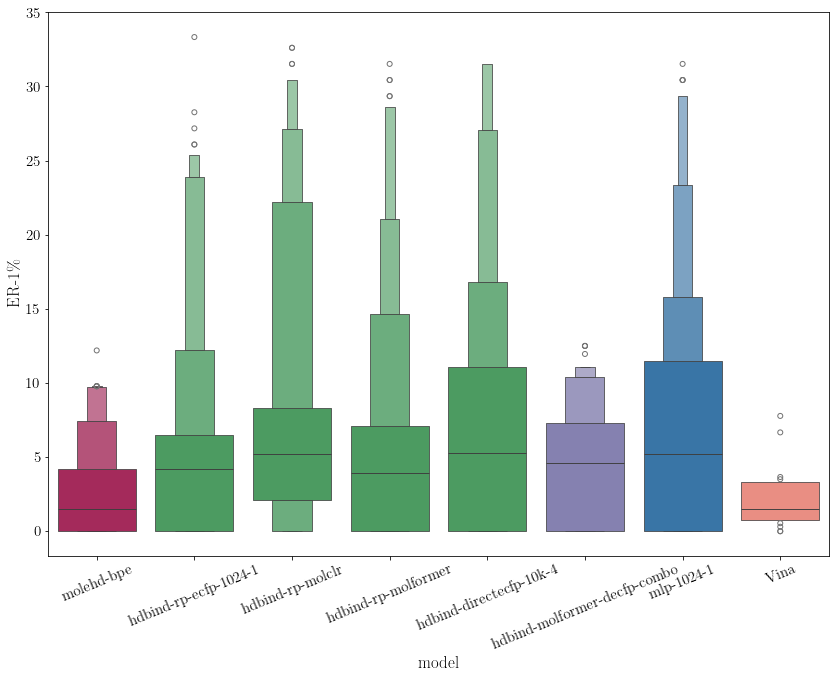

In [76]:
ave_f, ave_ax = plt.subplots(1,1, figsize=(14,10))
ave_ax = sns.boxenplot(data=ave_df, x="model", y="enrich", 
                  order=model_10k_list,
                  palette={key: model_dict[key][1] for key in model_10k_list},
                #   ax=ave_ax
                  )

print(ave_ax.get_xticklabels())
labels = [item.get_text() for item in ave_ax.get_xticklabels()]
print(labels)
# labels = [model_dict[item.get_text()][0] for item in ave_ax.get_xticklabels()]
# ave_ax.set_title(f"ER-1\%", fontdict={"fontsize": 18})
# ave_ax.set_xlabel("")
# ave_ax.set_ylabel("")
ave_ax.tick_params(axis="x", labelrotation=22.5)
# ave_ax.tick_params(axis="y", labelrotation=90)
# ave_ax.tick_params(axis="y", labelrotation=45)
# ave_ax.set_ylabel("ER-1\%", rotation=45)
ave_ax.set_ylabel("ER-1\%")
# print(ave_ax.get_xticklabels())
# labels = [model_dict[item.get_text()][0] for item in ave_ax.get_xticklabels()]

# ave_ax.set_xticklabels(labels)
# plt.tight_layout()

In [8]:
ave_df.describe()

,seed
count,1050.00000
mean,4.50000
std,2.87365
min,0.00000
25%,2.00000
50%,4.50000
75%,7.00000
max,9.00000


In [18]:
ave_df.groupby(["model"])["enrich"].mean()

model
Vina                            2.325644
hdbind-directecfp-10k-4         7.846744
hdbind-molformer-decfp-combo    4.716101
hdbind-rp-ecfp-1024-1           5.459023
hdbind-rp-molclr                7.994659
hdbind-rp-molformer             5.721039
mlp-1024-1                      7.609007
molehd-bpe                      2.634551
Name: enrich, dtype: float64

In [ ]:
random_df = compute_model_metric_df(model_dict=model_dict, model_list=model_10k_list, dataset="lit-pcba", split="random", target_list="all")
random_df.to_csv("lit-pcba-metrics-10k-random.csv")

In [ ]:
random_df.describe()

In [ ]:
random_df.groupby(["model", "p"]).median()